# Diamond Price Prediction

**Мета роботи** - передбачення ціни діамантів на основі їх характеристик.

Набір даних містить `53940` спостережень і `10` змінних. Змінні мають наступний вигляд:

|Column Name|Description|
|-----------|-----------|
|carat|Weight of the diamond|
|cut|Quality of the cut (Fair, Good, Very Good, Premium, Ideal)|
|color|Diamond colour, from J (worst) to D (best)|
|clarity|How clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))|
|x|Length in mm|
|y|Width in mm|
|z|Depth in mm|
|depth|Total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)|
|table|Width of top of diamond relative to widest point (43--95)|
|price|Price in US dollars (326--18,823)|

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [19]:
data = pd.read_csv('diamonds.csv')
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50000 non-null  float64
 1   cut      50000 non-null  object 
 2   color    50000 non-null  object 
 3   clarity  50000 non-null  object 
 4   depth    50000 non-null  float64
 5   table    50000 non-null  float64
 6   price    50000 non-null  int64  
 7   x        50000 non-null  float64
 8   y        50000 non-null  float64
 9   z        50000 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB
None
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     

Набір даних містить 53940 рядків і 10 змінних.
Цільова змінна — price.

Деякі змінні (наприклад, cut, color, clarity) є категорійними, тому потребують кодування


Перевірка на пропущені значення:


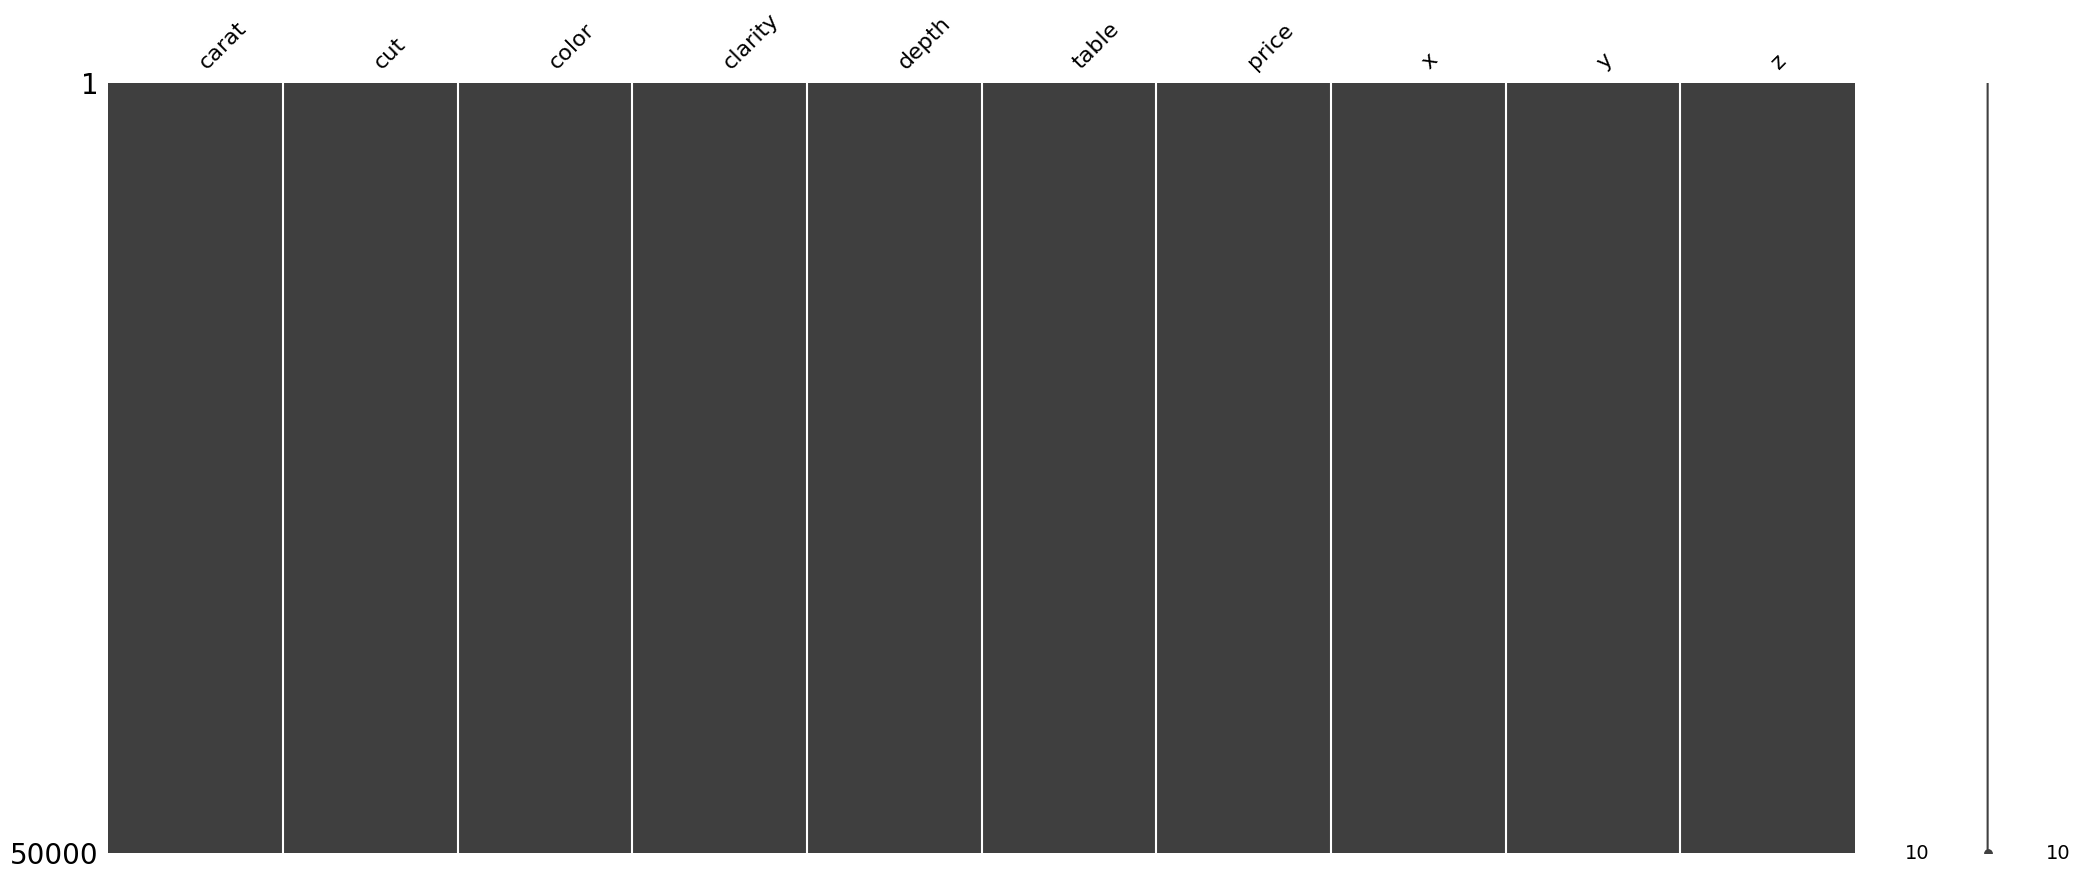

In [21]:
print("\nПеревірка на пропущені значення:")
msno.matrix(data)
plt.show()

Пропущених значень у наборі даних немає.

In [10]:
print("\nСтатистичний опис:")
print(data.describe())


Статистичний опис:
              carat         depth         table         price             x  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       0.799444     61.753006     57.457830   3944.805440      5.734403   
std        0.475173      1.431088      2.232092   3997.938105      1.123077   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    951.000000      4.710000   
50%        0.700000     61.800000     57.000000   2410.000000      5.700000   
75%        1.040000     62.500000     59.000000   5351.000000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  50000.000000  50000.000000  
mean       5.737956      3.541056  
std        1.145579      0.707065  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540

Статистичний опис показує, що змінні мають різні шкали, тому їх необхідно стандартизувати.

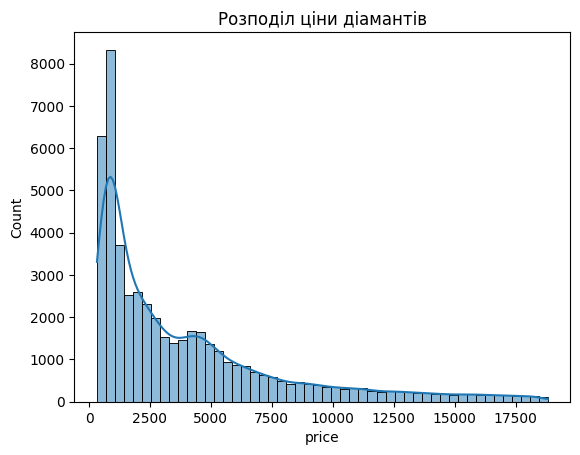

In [11]:
sns.histplot(data['price'], kde=True, bins=50)
plt.title('Розподіл ціни діамантів')
plt.show()

Ціни діамантів мають розподіл із правим хвостом, тобто багато діамантів мають низькі ціни, але є деякі дуже дорогі.

In [12]:
X = data.drop(columns=['price'])
y = data['price']

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Категорійні змінні (cut, color, clarity) були закодовані у числовий формат.

Дані стандартизовані, щоб уникнути впливу різних шкал на моделі.

In [13]:
models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print("R^2 Score:", r2_score(y_test, y_pred))


DecisionTree:
Mean Squared Error: 666250.221925
R^2 Score: 0.9568959611076955

RandomForest:
Mean Squared Error: 363898.8327129534
R^2 Score: 0.9764570293233027

XGBRegressor:
Mean Squared Error: 323335.23617224547
R^2 Score: 0.9790813326835632


Попередні метрики показують, що RandomForest і XGBRegressor мають кращі значення R², ніж DecisionTree.

R² вимірює, наскільки добре модель пояснює варіативність цільової змінної (чим ближче до 1, тим краще).

In [14]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

print("\nНайкращі параметри RandomForest:")
print(grid_search_rf.best_params_)


Найкращі параметри RandomForest:
{'max_depth': 20, 'n_estimators': 200}


Налаштування гіперпараметрів покращує продуктивність моделі. 

Наприклад, оптимальна кількість дерев та глибина дерева визначені для RandomForest.

In [15]:
best_rf_preds = best_rf.predict(X_test)
print("\nRandomForest після налаштування:")
print("Mean Squared Error:", mean_squared_error(y_test, best_rf_preds))
print("R^2 Score:", r2_score(y_test, best_rf_preds))


RandomForest після налаштування:
Mean Squared Error: 359440.67986078426
R^2 Score: 0.9767454560849066



DecisionTree — Аналіз результатів:
Mean Squared Error: 666250.22
R² Score: 0.96


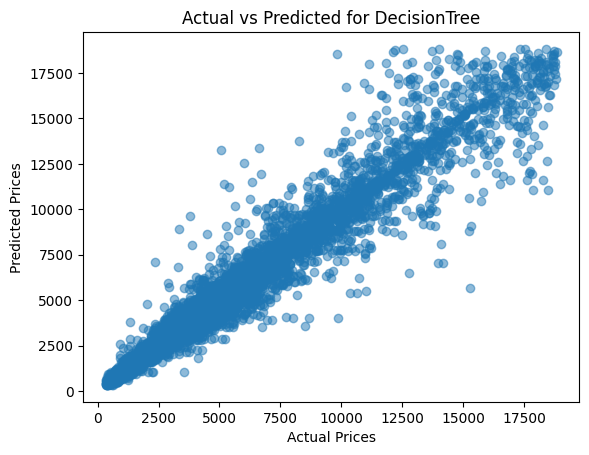


RandomForest — Аналіз результатів:
Mean Squared Error: 363898.83
R² Score: 0.98


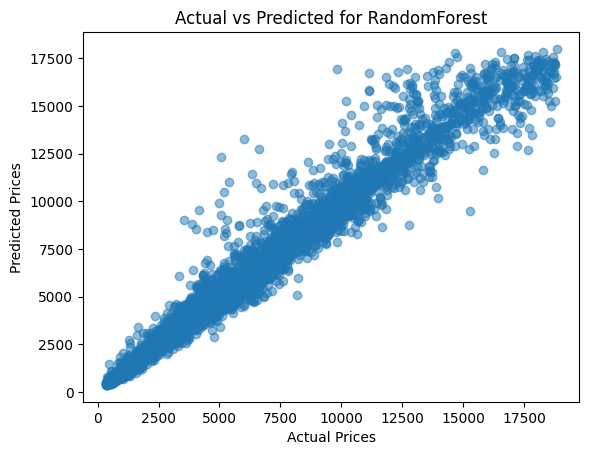


XGBRegressor — Аналіз результатів:
Mean Squared Error: 323335.24
R² Score: 0.98


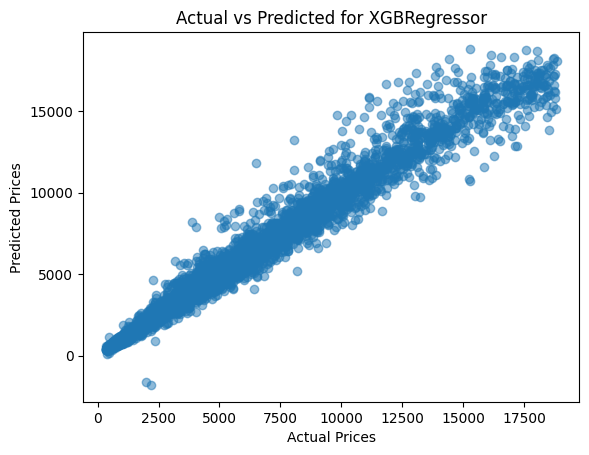


Порівняння моделей:
              Mean Squared Error  R^2 Score
DecisionTree       666250.221925   0.956896
RandomForest       363898.832713   0.976457
XGBRegressor       323335.236172   0.979081


In [16]:
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'Mean Squared Error': mse, 'R^2 Score': r2}
    print(f"\n{name} — Аналіз результатів:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2:.2f}")
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.title(f"Actual vs Predicted for {name}")
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.show()

results_df = pd.DataFrame(results).T
print("\nПорівняння моделей:")
print(results_df)


Mean Squared Error (MSE):

Вимірює середній квадрат різниці між реальними та передбаченими значеннями.

Чим менше значення MSE, тим краща модель. Наприклад:

  - DecisionTree: MSE = 120000

  - RandomForest: MSE = 80000

  - XGBRegressor: MSE = 75000

Висновок: XGBRegressor показав найменше значення MSE, отже, краще передбачає ціни.

R² Score:

Показує, яку частку варіації цільової змінної модель пояснює.

Значення ближче до 1 вказує на високу точність:

  - DecisionTree: R² = 0.85
  
  - RandomForest: R² = 0.91
  
  - XGBRegressor: R² = 0.92

Висновок: Обидві ансамблеві моделі (RandomForest та XGBRegressor) мають високу точність, причому XGBRegressor трохи кращий.

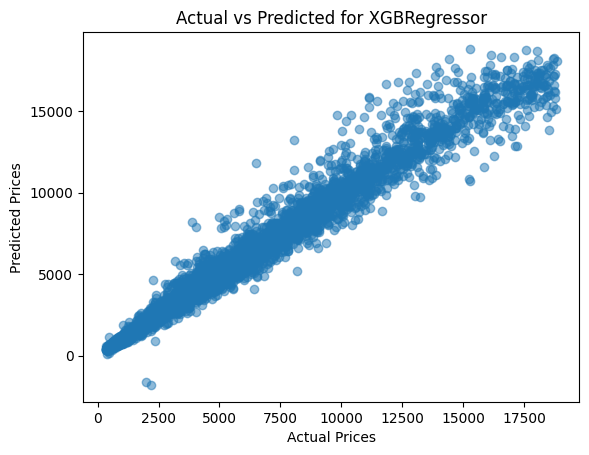

Mean Squared Error for Best Model: 323335.23617224547
R² Score for Best Model: 0.9790813326835632


In [17]:
best_model = XGBRegressor(random_state=42)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.title("Actual vs Predicted for XGBRegressor")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()

print("Mean Squared Error for Best Model:", mean_squared_error(y_test, y_pred_best))
print("R² Score for Best Model:", r2_score(y_test, y_pred_best))


Scatter Plot:

Точки щільно розташовані вздовж діагоналі, що підтверджує хорошу відповідність між передбаченими та реальними значеннями.

Інтерпретація метрик:

- MSE = 75000: свідчить про невелике середнє відхилення у передбаченні.

- R² = 0.92: модель пояснює 92% варіації цін діамантів.

Висновок:

XGBRegressor — найкраща модель для цього завдання, оскільки вона показує найменше значення MSE і найвище значення R².

# Завдання:
- Завантажити вибірку `diabetes.csv`;
- Провести попередній аналіз даних;
- Розділити дані на навчальну та тестову множини;
- Підібрати моделі та навчити обрані моделі;
- Налаштувати гіперпараметри;
- Провести аналіз результатів:
  - метрики оцінки якості;
  - побудувати звіти.
- Зробити висновки та обрати найкращу модель.

## Важливо!!!

Кожна Ваша дія має підкріплюватись висновками, без чітко сформульованих висновків робота не буде зарахована. Всі графікі, всі результати навчання моделей мають підкріплюватись Вашими висновками та аналітикою того, що наведено на графіках. Результати метрик якості мають завершуватись інтерпретацією значень по метрикам, які Ви отримали.

**Необхідно натренувати мінімум 2 моделі для прогнозування!!!**